In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from hubbard.hubbard import *
from hubbard.utilities import * 

In [2]:
tex_fonts = {
    "pgf.texsystem": "pdflatex",
    'pgf.rcfonts': False,
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [3]:
def params_calc(M, phi):
    j = np.arange(M)+1
    p_j = lambda q: np.sqrt(2/M) * np.cos(np.pi / M * q * (j-.5))
    a_j = lambda phi, phi_0: 1/np.sqrt(M) * np.exp(1j* (phi * j + phi_0))
    q = np.arange(M-1)+1
    Eq = np.cos(np.pi/M*q)-1
    E_gap_min = abs(np.cos(np.pi / M) - 1) 
    Omega = E_gap_min / 10
    A = np.empty(len(phi), dtype = np.complex64)
    fqp = np.empty((len(q), len(phi)), dtype = np.complex64)
    for i, q_i in enumerate(q):
        for k, phi_k in enumerate(phi):
            #phi_0 = 0
            phi_0 = -(M+1)/2 * phi_k
            #phi_0 = - 1/2 * phi_k
            fqp[i, k] = sum(p_j(q_i)*a_j(phi_k, phi_0))
            A[k] = sum(a_j(phi_k, phi_0))

    F_diag = abs(fqp)**2
    F_diag = [sum(F_diag[:,i] / Eq) for i in range(len(phi))]
    F_diag = np.array(F_diag)

    F_off = np.conj(fqp)**2
    F_off_2 = fqp**2

    #print(F_off.real == F_off_2.real)

    F_off = [sum(F_off[:,i] / Eq) for i in range(len(phi))]
    F_off = np.array(F_off)

    #print('Max Im[F_off]:', abs(F_off.imag).max())
    #print('Min Im[F_off]:', abs(F_off.imag).min())

    chi_z = Omega **2 / 2/(M-1) * F_diag
    chi_x = Omega **2 / 2/(M-1) * np.real(F_off)
    chi_xy = Omega **2 / 2/(M-1) * np.imag(F_off)

    A = A/M

    v_x = A.real * Omega / 2
    v_y = A.imag * Omega / 2
    
    return chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off

In [4]:
N = M = 500

spin = SpinModel(N, M, bc = 'open')

In [5]:
spin.set_scheme('parallel')
#spin.set_scheme('multiply')

(0.0, 1.1)

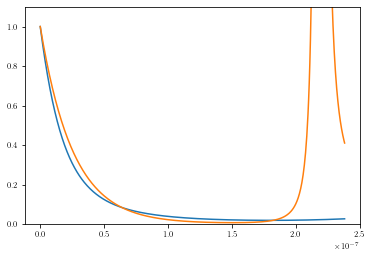

In [6]:
chi = 1e5
N_steps = 500
spin.S_calc()
spin.H = chi*spin.Sx**2
t, sq = spin.evolve(spin.initial_state(), t_f = 3/2*N**(-2/3)/chi, num = N_steps, parameters = ['squeezing'])
OAT_L = sq.min()

plt.plot(t, sq[0])

spin.H = chi*(spin.Sx**2-spin.Sy**2)
_, sq = spin.evolve(spin.initial_state(), t_f = 3/2*np.log(N)/(2*N)/chi, num = N_steps, parameters = ['squeezing'])
TACT_L = sq.min()

plt.plot(t, sq[0])

plt.ylim(0, 1.1)

In [7]:
n_x = 50

In [8]:
def best_sq_calc(phi_list, N_steps = 100):
    J_SE = 1
    
    E_gap = J_SE*abs(np.cos(np.pi/M)-1)
    Omega = E_gap/10
    print('E_gap:', E_gap)
    print('Omega:', Omega)
    
    ini_label = ['x','y','z']
    psi_list = [0, np.pi/2, 0]
    theta_list = [np.pi/2, np.pi/2, 0]

    std_lim = np.std(1-0.001*(.5-np.random.rand(N_steps)))
    
    full_data = []
    t_best = np.empty((len(phi_list), len(theta_list)))
    xi_best = np.empty((len(phi_list), len(theta_list)))
    wf0 = [spin.rotate((theta, psi), spin.initial_state()) for theta, psi in zip(theta_list, psi_list)]
    for i, phi in enumerate(phi_list):
        spin.H = spin.H_eff_open(J_SE, Omega, phi, phi_0 = -(M+1)/2*phi)

        _, _, _, chi_x, chi_z, _ = open_coeff(phi, N, M, J_SE, Omega, phi_0 = -(M+1)/2*phi)
        chi = chi_z + chi_x
            
        for j in range(len(theta_list)):
            t_f = 1/abs(chi)

            t = [0]
            sq = [1]
            wf = wf0[j]
            search = True
            end = 3#N_steps // 10
            while search:
                t_new, data = spin.evolve(wf, t_f = t_f, num = N_steps, 
                                          parameters = ['squeezing'], save_wf = True)
                wf = spin.wf_t[-1]
                t = np.concatenate((t, t_new+t[-1]))
                sq = np.concatenate((sq, data[0]))
                
                first_passage = sq > sq[2]
                first_passage[:end] = False
                t_f += t_f
                if any(first_passage):
                    t_1pass = t[first_passage][0]
                    mask = t < t_1pass
                    '''
                    if t_1pass < 1 / abs(chi) / 10:
                        print('Squeezing too fast!')
                        second_passage = [i for i in range(1, len(first_passage)) 
                                          if first_passage[i-1] == True and first_passage[i] == False]
                        second_passage = second_passage[0]
                        end = second_passage + 3
                        print(end, i, j)
                    el
                    '''
                    if len(t[mask]) < N_steps:
                    #if len(t[mask]) < (N_steps // 2):
                        t = [0]
                        sq = [1]
                        wf = wf0[j]
                        t_f = t_1pass
                    else:
                        search = False
                        t = t[mask]
                        sq = sq[mask]
                elif sq.std() < std_lim:
                    search = False

            t_best[i, j], xi_best[i, j] = calc_minima(t, sq)
            full_data.append((t, sq))
        
    return full_data, t_best, xi_best, ini_label

In [9]:
def plot_evo_full(full_data, t_best, ini, lim = None):
    fig, ax = plt.subplots()
    t_all = t_best[:, ini]
    if lim is None:
        lim = np.nanmax(t_all)
    for t, sq in full_data[ini::3]:
        if t[sq.argmin()] < lim:
            ax.plot(t, sq)

    ax.set_ylim(0., 1.1)
    ax.set_xlim(0,lim)
    
    return fig, ax

In [10]:
#figwidth = 3.416*2#*.45
def plot_opt_sq(x, t_best, xi_best, gamma, eta, label, phi_crit = None):
    fig, axs = plt.subplots(4, 1, 
                                   sharex = 'col',
                                   constrained_layout=True, 
                                   figsize=(10, 10)
                                   )
    phi = np.copy(x)
    phi /= 2*np.pi/N
    if phi_crit is not None:
        phi_crit /= 2*np.pi/N
    axs[-1].set_xlabel(r'$\phi\ \left[\frac{2\pi}{N}\right]$')

    axs[0].plot(phi, eta, color = 'k')
    axs[1].plot(phi, gamma, color = 'k')
    axs[0].set_ylabel(r'$\eta$')
    axs[1].set_ylabel(r'$\gamma$')
    axs[-2].set_ylabel(r'$\xi^2_\mathrm{best}$')
    axs[-1].set_ylabel('$t_\mathrm{best}$')
    x_ticks = [phi[0], phi_crit, phi[-1]] if phi_crit is not None else [phi[0], phi[len(phi)//2], phi[-1]]
    axs[-1].set_xticks(x_ticks)

    markers = '.', '1', '2'
    for j in range(len(ini_label)):
        axs[-2].scatter(phi, xi_best[:, j], marker = markers[j], label = ini_label[j])
        axs[-1].scatter(phi,  t_best[:, j], marker = markers[j], label = ini_label[j])

    #axs[-1].legend()
    
    axs[-2].axhline(TACT_L, color = 'tab:red', alpha = 0.5)
    axs[-2].axhline(OAT_L, color = 'tab:purple', alpha = 0.5)

    axs[-1].set_yscale("log")
    axs[-2].set_yscale('log')
    
    if phi_crit is not None:
        for ax in axs:
            ax.axvline(phi_crit, color = 'tab:grey', ls = 'dashed')
            
    colwidth = 3.416666
    fig.set_size_inches(w = colwidth, h = 1.3*colwidth)

    fig.savefig(f'output/best_sq_{label}_N{N}.pdf', format='pdf', bbox_inches='tight')

    fig.set_size_inches(w = 10, h = 10)
            
    return fig, axs

# And between $\pi-3\pi/M$ and $\pi - \pi/M$?

In [11]:
phi_npi = 2*np.pi/M*np.linspace(M//2-1.5, M//2-.5, n_x)

In [12]:
chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_npi)

eta = chi_x / chi_z

phi = phi_npi[eta < 0]

#phi_npi = np.linspace(phi[0], phi[-1], n_x)

phi_npi = np.concatenate((np.linspace(phi[0], np.pi-2*np.pi/M, n_x//2, endpoint = False), 
                        np.linspace(np.pi-2*np.pi/M, phi[-1], n_x//2)))

chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_npi)

eta_npi = chi_x / chi_z
gamma_npi = v_x / chi_z

In [ ]:
full_data_npi, t_best_npi, xi_best_npi, ini_label = best_sq_calc(phi_npi)

E_gap: 1.9739143862884667e-05
Omega: 1.9739143862884665e-06


/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 1.9631041980406284e-08
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -3.3792248507075707e-07
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.685218853599994e-07
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 2.1114989153275172e-05
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserW

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.00021938214054528343
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.00016444607765387146
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.0011770574380208982
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.00021901683241381108
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: User

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.0005683488146623838
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.0013897653799276083
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.0031900309781371186
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.0019035195961284775
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: -0.0003288920570042724
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.00016444599785645682
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.0002184818689052468
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWarning: Squeezing imaginary part is non negligible: 0.00021956106263994668
  warnings.warn(f'Squeezing imaginary part is non negligible: {np.imag(squeezing)}')
/home/tana/Documents/Code/1d-hubbard-model/hubbard/hubbard.py:237: UserWa

In [ ]:
data = {'phi': phi_npi, 't_best': t_best_npi, 'xi_best': xi_best_npi, 
        'eta': eta_npi, 'gamma': gamma_npi, 'full_data': full_data_npi}
#np.save(f'output/incomm_sq_npi_N{N}', data)
np.savez(f'output/incomm_sq_npi_N{N}', **data)

In [ ]:
fig, ax = plot_evo_full(data_npi['full_data'], data_npi['t_best'], ini = 1, lim = 1e13)

plt.ylim(0.05, .075)


In [ ]:
phi = data_npi['phi']/(2*np.pi/100)
phi[-12]
print(data_npi['t_best'][-13, 2])

max(data_npi['t_best'][:, 2])


x, y = data_npi['full_data'][-13*3]

plt.plot(x,y)

In [ ]:
fig, _ = plot_opt_sq(phi_npi, t_best_npi, xi_best_npi, gamma_npi, eta_npi, label = 'npi', phi_crit = np.pi-2*np.pi/M)

# Finally, what about the incommensurte phase between $\pi-4\pi/M$ and $\pi - 2\pi/M$?

In [ ]:
phi_inc = 2*np.pi/M*np.linspace(M//2-2, M//2-1, n_x)

In [ ]:
chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_inc)

eta = chi_x / chi_z

phi = phi_inc[eta > 0]

#phi_npi = np.linspace(phi[0], phi[-1], n_x)

phi_inc = np.concatenate((np.linspace(phi[0], np.pi-3*np.pi/M, n_x//2, endpoint = False), 
                        np.linspace(np.pi-3*np.pi/M, phi[-1], n_x//2)))

chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_inc)

eta_inc = chi_x / chi_z
gamma_inc = v_x / chi_z

In [ ]:
full_data_inc, t_best_inc, xi_best_inc, ini_label = best_sq_calc(phi_inc)

In [ ]:
data = {'phi': phi_inc, 't_best': t_best_inc, 'xi_best': xi_best_inc, 
        'eta': eta_inc, 'gamma': gamma_inc, 'full_data': full_data_inc}
#np.save(f'output/incomm_sq_inc_N{N}', data)
np.savez(f'output/incomm_sq_inc_N{N}', **data)

In [ ]:
plot_evo_full(full_data_inc, t_best_inc, ini = 1, lim = 5e7)

In [ ]:
fig, _ = plot_opt_sq(phi_inc, t_best_inc, xi_best_inc, gamma_inc, eta_inc, 
                     label = 'inc', phi_crit = np.pi-3*np.pi/M)

# Squeezing for $\eta > 0$ around $\pi$

In [ ]:
phi_pi = 2*np.pi/M*np.linspace(M//2-.5, M//2+.5, n_x)

In [ ]:
chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_pi)

eta = chi_x / chi_z

phi = phi_pi[eta < 0]

phi_pi = np.concatenate((np.linspace(phi[0], np.pi, n_x//2, endpoint = False), 
                        np.linspace(np.pi, phi[-1], n_x//2)))
print(phi_pi)

chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_pi)

eta_pi = chi_x / chi_z
gamma_pi = v_x / chi_z

In [ ]:
full_data_pi, t_best_pi, xi_best_pi, ini_label = best_sq_calc(phi_pi)

In [ ]:
plot_evo_full(full_data_pi, t_best_pi, ini = 1, lim = 4e3)

In [ ]:
data = {'phi': phi_pi, 't_best': t_best_pi, 'xi_best': xi_best_pi, 
        'eta': eta_pi, 'gamma': gamma_pi, 'full_data': full_data_pi}
#np.save(f'output/incomm_sq_pi_N{N}', data)
for _, value in data.items():
    print(type(value))
np.savez(f'output/incomm_sq_pi_N{N}', **data)

In [ ]:
fig, _ = plot_opt_sq(phi_pi, t_best_pi, xi_best_pi, gamma_pi, eta_pi, label = 'pi', phi_crit = np.pi)

# What about the squeezing between $\pi/M$ and $2\pi/M$?

In [ ]:
phi_1 = 2*np.pi/M*np.linspace(0.5, 1, n_x)

In [ ]:
chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_1)

eta = chi_x / chi_z

phi = phi_1[eta < 0]

phi_1 = np.linspace(phi[0], phi[-1], n_x)

chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off = params_calc(M, phi_1)

eta_1 = chi_x / chi_z
gamma_1 = v_x / chi_z

In [ ]:
full_data_1, t_best_1, xi_best_1, ini_label = best_sq_calc(phi_1)

In [ ]:
data = {'phi': phi_1, 't_best': t_best_1, 'xi_best': xi_best_1, 
        'eta': eta_1, 'gamma': gamma_1, 'full_data': full_data_1}
#np.save(f'output/incomm_sq_1_N{N}', data)
np.savez(f'output/incomm_sq_1_N{N}', **data)

In [ ]:
plot_evo_full(full_data_1, t_best_1, ini = 1, lim = None)

In [ ]:
fig, _ = plot_opt_sq(phi_1, t_best_1, xi_best_1, gamma_1, eta_1, label = '1', phi_crit = 2*np.pi/M)

# More plotting!

In [ ]:
#figwidth = 3.416*2#*.45
def plot_opt_sq_all(N, ini, args):
    L = len(args)
    fig, axs = plt.subplots(2, L, 
                            sharex = 'col',
                            sharey = 'row',
                            constrained_layout=True, 
                            )
    
    c1 = 'tab:blue'
    c2 = 'tab:orange'
    c3 = 'tab:green'
    c4 = 'tab:red'
    
    for i, data in enumerate(args):
        x = np.copy(data['phi'])
        x /= 2*np.pi/N
        phi_crit = None
        if phi_crit is not None:
            phi_crit /= 2*np.pi/N
        ax1 = axs[0, i]
        ax1.tick_params(axis='y', labelcolor=c1)
        ax2 = axs[0, i].twinx()
        ax2.label_outer()
        ax2.tick_params(axis='y', labelcolor=c2)
        ax3 = axs[1, i]
        ax3.tick_params(axis='y', labelcolor=c3)
        ax4 = axs[1, i].twinx()
        ax4.label_outer()
        ax4.tick_params(axis='y', labelcolor=c4)
        if i == 0:
            ax_gamma = ax2
            ax_tbest = ax4
        else:
            ax2.sharey(ax_gamma)
            ax4.sharey(ax_tbest)
            
        
        ax3.set_xlabel(r'$\phi N/(2\pi)$')

        ax1.plot(x, data['eta'], color = c1)
        ax2.plot(x, data['gamma'], color = c2)
        
        #x_ticks = [phi[0], phi_crit, phi[-1]] if phi_crit is not None else [phi[0], phi[len(phi)//2], phi[-1]]
        #ax3.set_xticks(x_ticks)

        #ax3.scatter(x, data['xi_best'][:, ini], marker = '1', color = c3)
        #ax4.scatter(x,  data['t_best'][:, ini], marker = '2', color = c4)        
        ax3.plot(x, data['xi_best'][:, ini], color = c3)
        
        J_SE = 1
    
        E_gap = J_SE*abs(np.cos(np.pi/M)-1)
        Omega = E_gap/10
        c = Omega**2/J_SE
        ax4.plot(x,  c*data['t_best'][:, ini], color = c4)

        #ax3.axhline(TACT_L, color = 'tab:red', alpha = 0.5)
        #ax3.axhline(OAT_L, ls = 'dashed', color = 'tab:purple', alpha = 0.5)

        ax3.set_yscale("log")
        ax4.set_yscale("log")
    
        if phi_crit is not None:
            for ax in axs[:,i]:
                ax.axvline(phi_crit, color = 'tab:grey', ls = 'dashed')
            
    axs[0, 0].set_ylabel(r'$\eta$', color = c1)
    ax2.set_ylabel(r'$\gamma$', color = c2)
    axs[1, 0].set_ylabel(r'$\xi^2_\mathrm{best}$', color = c3)
    ax4.set_ylabel(r'$\frac{\Omega^2}{J_\mathrm{SE}}t_\mathrm{best}$', color = c4)
        
    colwidth = 3.416666
    fig.set_size_inches(w = 2*colwidth, h = colwidth)
    textwidth = 7.06
    fig.set_size_inches(w = textwidth, h = .5*textwidth)

    label = 'xyz'[ini]
    fig.savefig(f'output/best_sq_{label}_N{N}.pdf', format='pdf', bbox_inches='tight')
    
    for ax in axs.flatten():
        ax.label_outer()

    #fig.set_size_inches(w = 10, h = 10)
            
    return fig, axs

In [ ]:

data_pi = np.load(f'output/incomm_sq_pi_N{N}.npz', allow_pickle = True)
data_1 = np.load(f'output/incomm_sq_1_N{N}.npz', allow_pickle = True)
data_npi = np.load(f'output/incomm_sq_npi_N{N}.npz', allow_pickle = True)
data_inc = np.load(f'output/incomm_sq_inc_N{N}.npz', allow_pickle = True)

fig, _ = plot_opt_sq_all(N, 2, (data_1, data_inc, data_npi, data_pi))

In [ ]:
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)

def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax2 : the zoomed axes
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

In [ ]:
N = M = 100

#fig = plt.figure(constrained_layout=True)
fig = plt.figure(constrained_layout=False)

ini = 2

c1 = 'k'
c0 = 'tab:blue'
c2 = 'tab:orange'
c3 = 'tab:green'
c4 = 'tab:red'

gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax12 = ax1.twinx()
ax2 = fig.add_subplot(gs[0, 1:])
ax22 = ax2.twinx()
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
xlabel = '$\phi N / (2\pi)$'
ax1.xaxis.set_label_position('top')
ax2.xaxis.set_label_position('top')
ax1.set_xlabel(xlabel)
ax2.set_xlabel(xlabel)

#ax1.axhline(0, ls = 'dashed', color = 'tab:grey')
#ax2.axhline(0, ls = 'dashed', color = 'tab:grey')

L = 2*np.pi/N
x1 = np.linspace(0, 2, 100)
ax1.set_xlim((0, 2))
x2 = np.linspace(M//2-2, M//2+1, 100)
ax2.set_xlim(((M//2-2), (M//2+1)))

#chi_z, chi_x, chi_xy, v_x, v_y, F_diag, F_off 
cz, cx, _, vx, vy, _, _ = params_calc(M, L*x1)
e1 = cx/cz
g1 = vx/cz

cz, cx, _, vx, vy, _, _ = params_calc(M, L*x2)
e2 = cx/cz
g2 = vx/cz

ax1.plot(x1, e1, color = c1)

x1_int = np.arange(1, 3)
cz, cx, _, vx, vy, _, _ = params_calc(M, L*x1_int)
e1_int = cx/cz
g1_int = vx/cz

ax1.scatter(x1_int, e1_int, marker = 'o', facecolor = 'none', color=c1)
ax12.scatter(x1_int, g1_int, marker = 'o', facecolor = 'none', color=c2)


x2_int = np.arange((M//2-2), (M//2+1)+1)
cz, cx, _, vx, vy, _, _ = params_calc(M, L*x2_int)
e2_int = cx/cz
g2_int = vx/cz

ax2.scatter(x2_int, e2_int, marker = 'o', facecolor = 'none', color=c1)
ax22.scatter(x2_int, g2_int, marker = 'o', facecolor = 'none', color=c2)

ax12.plot(x1, g1, color = c2)

ax2.plot(x2, e2, color = c1)
#ax2.sharey(ax1)
#ax22.sharey(ax12)
ax22.plot(x2, g2, color = c2)

g_lim = np.max(abs(g1[1:]))/60

ax2.set_yticks([])
ax12.set_yticks([])
ax1.set_ylim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax12.set_ylim(-g_lim, g_lim)
ax22.set_ylim(-g_lim, g_lim)
ax1.set_ylabel(r'$\eta$', color = c1)
ax22.set_ylabel(r'$\gamma$', color = c2)
ax1.tick_params(axis='y', labelcolor=c1)
ax22.tick_params(axis='y', labelcolor=c2)

sources = data_1, data_inc, data_npi, data_pi
focus = ax1, ax2, ax2, ax2
facecolors = c0, c4, c0, c0
'''
xi_max = max([data['xi_best'].max() for data in sources])
xi_min = min([data['xi_best'].min() for data in sources])
xi_lim = xi_min, xi_max
'''
xi_lim = TACT_L*8.5e-1, OAT_L*11e-1
'''
t_max = max([data['t_best'].max() for data in sources])
t_min = min([data['t_best'].min() for data in sources])
t_lim = t_min, t_max
'''
t_lim = 1e-2, 10

marker = '.'

for i in range(len(sources)):
    main_ax = focus[i]
    data = sources[i]
    ax = fig.add_subplot(gs[1, i])
    axp = ax.twinx()
    x = data['phi']/L
    xlim = x[0], x[-1]
    #ax.plot(x, data['xi_best'][:, ini], color = c3)
    ax.scatter(x, data['xi_best'][:, ini], marker = marker, color = c3)
    ax.axhline(OAT_L, ls = 'dotted', color = c3)
    ax.axhline(TACT_L, ls = 'dashed', color = c3)
    y = data['t_best'][:, ini]
    cz, cx, _, vx, vy, _, _ = params_calc(M, data['phi'])
    y *= abs(cz)
    #axp.plot(x, y, color = c4)
    axp.scatter(x, y, marker = marker, color = c4)
    #ax.sharey(ax3)
    #axp.sharey(ax3p)
    ax.set_xlabel(xlabel)
    axp.set_xlabel(xlabel)
    ax.set_xlim(xlim)
    ax.set_ylim(xi_lim)
    axp.set_ylim(t_lim)
    #ax.set_yscale('log')
    axp.set_yscale('log')
    if i > 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel(r'$\xi^2_\mathrm{best}$', color = c3)
        ax.tick_params(axis='y', labelcolor=c3)
        delta = 2e-2
        ax.text(0.75, OAT_L*(1+delta), 'OAT', horizontalalignment = 'center', color = c3)
        ax.text(0.75, TACT_L*(1-delta), 'TACT', horizontalalignment = 'center', 
                verticalalignment = 'top', color = c3)
    if i < len(sources)-1:
        axp.set_yticks([])
    else:
        axp.set_ylabel(r'$\chi_z t_\mathrm{best}$', color = c4) #\frac{\Omega^2}{J_\mathrm{SE}}
        axp.tick_params(axis='y', labelcolor=c4)
        
    zoom_effect(ax, main_ax, facecolor = facecolors[i])
    
    #ax.set_yscale('log')
#for ax in fig.axes:
#    ax.label_outer()

colwidth = 3.416666
fig.set_size_inches(w = 2*colwidth, h = colwidth)
textwidth = 7.06
fig.set_size_inches(w = textwidth, h = .5*textwidth)

panels_label = 'abcdefgh'

ax1.xaxis.grid()
ax1.axhline(0, color='gray', linewidth=0.5)
ax2.grid()
ax2.axhline(0, color='gray', linewidth=0.5)

for i, ax in enumerate(fig.axes[4::2]):
    ax.text(0.05, 0.88, f'({panels_label[i]})', transform=ax.transAxes)

label = 'xyz'[ini]
fig.savefig(f'output/best_sq_zoom_{label}_N{N}.pdf', format='pdf', bbox_inches='tight')